In [17]:
#import python packages
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.optimize as opt

In [18]:
#define functions
def IEL_model(mm_pos, toehold_range, b, R, temp, inv_conc, dGbp, dGmm, dGbm, dGp, dGassoc, k_bp):
    
    log_k_eff = np.empty(len(mm_pos))
    k_eff = np.empty(len(mm_pos))
    first_pass_time = np.empty(len(mm_pos))
    prob_unbound = np.empty(len(mm_pos))

    for ind, m in enumerate(mm_pos):
        
        g = toehold_range[ind]
        
        #define forward and reverse transition rates
        k_AA = 0;
        k_AB1 = k_bp * np.exp(-dGassoc) * (inv_conc)
        k_B1A = k_bp * np.exp(dGbp)
        k_BC1ij = k_bp;
        k_BC1ji = k_bp * np.exp(dGbp);
        k_C1f = k_bp * np.exp(-(dGbm + dGp))
        k_Cf = k_bp * np.exp(-dGbm)
        k_Cr = k_bp * np.exp(-dGbm);
        k_Crm = k_bp * np.exp((dGmm[ind]-dGbm))
        k_CD = k_bp * np.exp(-dGbm)
        k_DC = 0 
        k_DD = 1
    
        #create arrays of forward and reverse transition rates for mismatch
        #systems
        Kf = np.array([k_DD, k_CD, k_C1f, k_BC1ij, k_AB1])
        Kf = np.insert(Kf, 2, np.repeat(k_Cf, b-2))
        Kf = np.insert(Kf, -2, np.repeat(k_BC1ij, [g-2]))
        
        Kb = np.array([k_DC, k_Cr, k_BC1ji, k_B1A, k_AA])
        Kb = np.insert(Kb, 1, np.repeat(k_Cr, b-2))
        Kb = np.insert(Kb, -3, np.repeat(k_BC1ji, g-2))
        Kb[b-m] = k_Crm
    
        #define spontaneous incumbent dissociation rates
        Koff = np.array([0]);
        for n in range(1, b):
            Koff = np.append(Koff, [k_bp*np.exp(-(n*(-dGbp)))]);
        Koff = np.append(Koff, np.repeat(0,  g+1))
    
        Pn_jN_1 = np.empty(len(Kf))
        jn_jN_1 = np.empty(len(Kf))
        Pn_jN_1[0] = 0;
        jn_jN_1[0] = 1;
        
        #calculate flux between each state for mismatch system
        for Pn in range(1, len(Kf)):
            Pn_jN_1[Pn]  = 1/Kf[Pn] * jn_jN_1 [Pn-1] + (Kb[Pn-1]/Kf[Pn])*Pn_jN_1[Pn-1];
            jn_jN_1[Pn] = jn_jN_1[Pn-1] + Koff[Pn] * Pn_jN_1[Pn];
    
        first_pass_time [ind] = (1/jn_jN_1[-2])*sum(Pn_jN_1) #first passage time for mismatch system
        k_eff [ind] = 1/(first_pass_time [ind]*(inv_conc)); #effective rate constant for mismatch system
        prob_unbound[ind] = Pn_jN_1[-1]/sum(Pn_jN_1) #probability of being in unbound state for mismatch system
        log_k_eff[ind] = np.log10(k_eff[ind])
    
    return log_k_eff

def fit_IEL_model(params, k_eff_exp, data_error):
    dGbm = params[0]
    dGp = params[1]
    k_bp = 10**params[2]
    
    log_k_eff = IEL_model(mm_pos, toehold_range, b, R, temp, inv_conc, dGbp, dGmm, dGbm, dGp, dGassoc, k_bp)
    
    return (log_k_eff - k_eff_exp)/data_error

In [19]:
#define experimental parameters
temp = 298.15 #temperature in K
R = 1.987/1000 #universal gas constant in kcal/K/mol 
inv_conc = 6*10**-8 #initial concentration of unbound invader
mm_pos = [0, 0, 0, 0, 18, 11, 1] #range of mismatch positions
toehold_range = [2, 3, 4, 6, 6, 6, 6] #range of toehold lengths
b = 20 #branch migration domain length 

dGmm = [0, 0, 0, 0, 3.23*(1/(R*temp)), 5.43*(1/(R*temp)), 6.76*(1/(R*temp))]#free energy penalty due to mismatch in kBT
dGbp = -2.57*(1/(R*temp)) #free energy gain due to base pair formation in kBT
dGassoc = 7.1*(1/(R*temp)) #free energy of RNA/RNA association in kBT

In [20]:
#import and save experimentally-derived rate constant
k_eff_exp = np.array([4.723, 4.525, 5.161, 7.326, 7.897, 4.443, 3.958])
data_error = np.array([0.0121, 0.00255, 0.00108, 0.101, 0.166, 0.00254, 0.00561])

In [21]:
params = [7.4, 3.6, np.log10(5.4*10**7)] #estimates of parameters to be fit (in kBT)
opt_params = opt.least_squares(fit_IEL_model, params, bounds = ([0, 0, 0], [15., 15., 15.]), args=(k_eff_exp, data_error))
print(opt_params)

 active_mask: array([0, 0, 0])
        cost: 19823.77383028585
         fun: array([-149.901522  ,   44.95959503,  -12.93484047,  -21.44596048,
        -16.49271694,   63.63795052, -101.02810698])
        grad: array([-6.03441462e-02, -1.25612584e-01, -2.05818797e-05])
         jac: array([[ 5.16263197e-01, -3.56906712e+01,  8.26446281e+01],
       [ 1.71770946e+00, -1.18917932e+02,  3.92156863e+02],
       [ 1.52199647e-01, -1.18141301e+01,  9.25925926e+02],
       [-2.02613432e-04, -2.25781875e-04,  9.90099008e+00],
       [-2.03479390e-03, -4.64077570e-03,  6.02409640e+00],
       [-1.18925472e+02, -1.23266482e+02,  3.93700785e+02],
       [-7.49316710e+01, -7.60958686e+01,  1.78253119e+02]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 12
        njev: 12
  optimality: 1.0527827558101086
      status: 2
     success: True
           x: array([ 9.14073421,  6.61881143, 10.37056193])


[2.90919158 4.63964697 5.14703037 5.15995799 5.15920899 4.60464039
 3.39123232]


Text(0, 0.5, 'log(keff)')

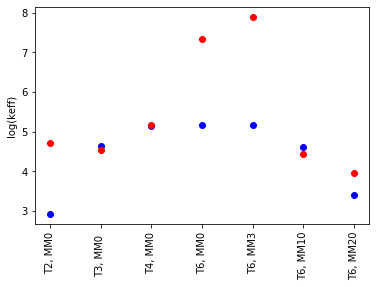

In [22]:
#plotting the fits 
dGbm = opt_params.x[0]
dGp = opt_params.x[1]
k_bp = 10**opt_params.x[2]

log_k_eff = IEL_model(mm_pos, toehold_range, b, R, temp, inv_conc, dGbp, dGmm, dGbm, dGp, dGassoc, k_bp)
print(log_k_eff)

plt.plot(log_k_eff, 'bo')
data_xticks = ['T2, MM0','T3, MM0 ','T4, MM0','T6, MM0', 'T6, MM3', 'T6, MM10', 'T6, MM20']
plt.xticks(range(7), data_xticks, rotation = 90)
plt.plot(k_eff_exp, 'ro')
plt.ylabel('log(keff)')

In [25]:
#parameter uncertainty
n_obs = len(k_eff_exp) #define the number of observations
n_params = len(params) #define the number of parameters
df = n_obs - n_params #define the number of degrees of freedom
wrss = np.sum(opt_params.fun**2) # weighted residual sum-of-squares

hess = np.dot(opt_params.jac.T, opt_params.jac)
cov = np.linalg.inv(hess)*wrss/df #define the covariance matrix

sd = np.sqrt(np.diag(cov)) #define the standard deviation
CI_95_l = opt_params.x-1.96*sd # lower bounds of 95% parameter confidence intervals
CI_95_u = opt_params.x+1.96*sd # upper bounds of 95% parameter confidence intervals

print('sd = ', sd)
print('lower 95% confidence interval = ', CI_95_l)
print('upper 95% confidence interval = ', CI_95_u)

sd =  [1.07494141 0.89929767 0.11232993]
lower 95% confidence interval =  [ 7.03384904  4.856188   10.15039527]
upper 95% confidence interval =  [11.24761937  8.38143487 10.59072858]
